Bayan Nezamabad 20251971
Jacob Beck 21304149

Code executes to the end without errors

### References:
[The dataset](https://www.kaggle.com/datasets/shahidulugvcse/national-flowers) <br>
[Understanding GoogLeNet Model - CNN Architecture](https://www.geeksforgeeks.org/understanding-googlenet-model-cnn-architecture/) <br>
[Going Deeper with Convolutions](https://arxiv.org/pdf/1409.4842) <br>
[TensorFlow Tutorials](https://www.tensorflow.org/tutorials) <br>
[Matplotlib Docs](https://matplotlib.org/stable/)

In [ ]:
# Imports
import kagglehub
import os

from keras import utils, Model
from keras.api.layers import Dense, Dropout, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Concatenate, Input, Flatten
from keras.api.initializers import GlorotUniform, HeNormal
from keras.api.optimizers import SGD, RMSprop, Adam, Lion
from keras.api.callbacks import EarlyStopping

#import keras_tuner as kt

import tensorflow as tf

import matplotlib.pyplot as plt
from matplotlib import image as mpimg

In [ ]:
# Downloading dataset from Kaggle
path = kagglehub.dataset_download("shahidulugvcse/national-flowers")

print("Path to dataset files:", path)

Resuming download from 195035136 bytes (15157845 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/shahidulugvcse/national-flowers?dataset_version_number=1 (195035136/210192981) bytes left.


100%|██████████| 200M/200M [00:01<00:00, 8.28MB/s]

Extracting model files...


Path to dataset files: /root/.cache/kagglehub/datasets/shahidulugvcse/national-flowers/versions/1


## The data set
Our dataset consists of images of 9 different types of national flowers which we will be classifying.
The total dataset consists of 4481 files, split roughly 80% training and 20% testing. <br>
Upon loading the dataset, some preprocessing is performed to make all images 224x224 since that is the requisite input size for GoogLeNet.

In [ ]:
# Loading the data set
train_dir = path + '/flowerdataset/train'
test_dir = path + '/flowerdataset/test'

# GoogLeNet configurations
input_shape = (224, 224)
batch_size = 128

verbose = True
NB_CLASSES = 9
class_names = os.listdir(train_dir)
#class_names = ["Daisy", "Dandelion", "Lavender", "Lily", "Lotus", "Orchid", "Rose", "Sunflower", "Tulip"]

# Loading our training dataset
train_ds = utils.image_dataset_from_directory(
    directory=train_dir,
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=input_shape, # Images are resized to the correct dimensions
    shuffle=False,
    verbose=verbose)

# Loading our testing dataset
test_ds = utils.image_dataset_from_directory(
    directory=test_dir,
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=input_shape, # Images are resized to the correct dimensions
    shuffle=False,
    verbose=verbose)

Found 3600 files belonging to 9 classes.
Found 881 files belonging to 9 classes.


### Data preprocessing
For data preprocessing the first step is normalisation. We will use min-max normalisation to make all pixel values from the range 0 - 255 to 0 - 1.

In [ ]:
# Loading the data set
# The train directory contains directories for each class/flower
train_dir = path + '//flowerdataset//train'
# The test directory contains directories for each class/flower
test_dir = path + '//flowerdataset//test'

# GoogLeNet configurations
input_shape = (256, 256)
batch_size = 128
epochs = 30

verbose = True
class_names = os.listdir(train_dir) # Getting class names based on directory names as each class' data is in a separate directory
NB_CLASSES = len(class_names)

# Loading our training dataset
train_ds = utils.image_dataset_from_directory(
    directory=train_dir,
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=input_shape, # Images are resized to the correct dimensions
    pad_to_aspect_ratio=True, # Padding images so as not to lose valuable features & preserve aspect ratio
    validation_split=0.2, # Reserve 20% of our dataset for validation
    subset='training', # Take the 80% of training data
    seed=123, # Use a seed for reproducibility
    verbose=verbose)

# Loading the remainder of our training dataset as our validation dataset
valid_ds = utils.image_dataset_from_directory(
    directory=train_dir,
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=input_shape, # Images are resized to the correct dimensions
    pad_to_aspect_ratio=True, # Padding images so as not to lose valuable features & preserve aspect ratio
    validation_split=0.2, # Reserve 20% of our dataset for validation
    subset='validation', # Take the 20% of validation data
    seed=123, # Use a seed for reproducibility
    verbose=verbose)

# Loading our testing dataset
test_ds = utils.image_dataset_from_directory(
    directory=test_dir,
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=input_shape, # Images are resized to the correct dimensions
    pad_to_aspect_ratio=True, # Padding images so as not to lose valuable features & preserve aspect ratio
    seed=123,
    verbose=verbose)

Found 3600 files belonging to 9 classes.
Using 2880 files for training.
Found 3600 files belonging to 9 classes.
Using 720 files for validation.
Found 881 files belonging to 9 classes.


<ipython-input-6-32abf732d11e>:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1, 3, 1)


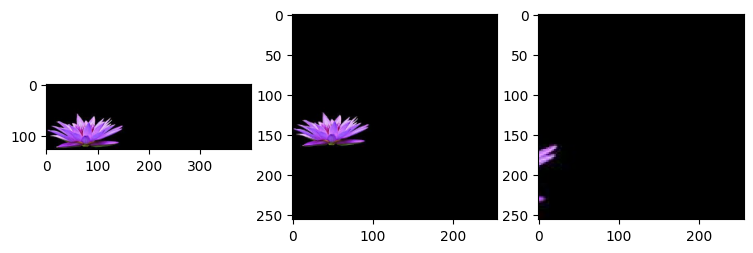

In [ ]:
# Padding vs cropping
plt.figure(figsize=(9, 6))
plt.title('Unaltered image vs Padded image vs Cropped image')
plt.axis('off')
image_path = train_dir + '//Lilly//334c1f79fd.jpg'

# Displaying unaltered image
ax = plt.subplot(1, 3, 1)
img = mpimg.imread(image_path) / 255.0
plt.imshow(img)

# Displaying padded image
ax = plt.subplot(1, 3, 2)
img = tf.convert_to_tensor(img, dtype=tf.float32)  # resize_with_pad takes a tensor so we convert the image into one here
img = tf.image.resize_with_pad(img, 256, 256)  # generates black (0) padding where needed
plt.imshow(img.numpy())

# Displaying cropped image
ax = plt.subplot(1, 3, 3)
img = utils.load_img(image_path, target_size=input_shape, keep_aspect_ratio=True)  # keep_aspect_ratio crops from the center
plt.imshow(img)

plt.show()

In [ ]:
# Min-max normalisation
# x represents image data so we divide it by 255 to normalise each image's pixel values
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
valid_ds = valid_ds.map(lambda x, y: (x / 255.0, y))
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

### Data visualisation

Here we will visualise some of the data.<br>
First we will display a sample image of each class from the training dataset.
The images contain varying backgrounds and were originally of varying dimensions but we have scaled them all down to 224x224 for use with our models.<br><br>
Next we will display the class distribution for the training dataset and the testing dataset. As can be seen, the training dataset is entirely evenly distributed, and the testing dataset is also evenly distributed for the most part.<br>The only minor difference is that there are 92 test images for the Daisy class and 89 for the Orchid class. Every other class has 100 test images each.



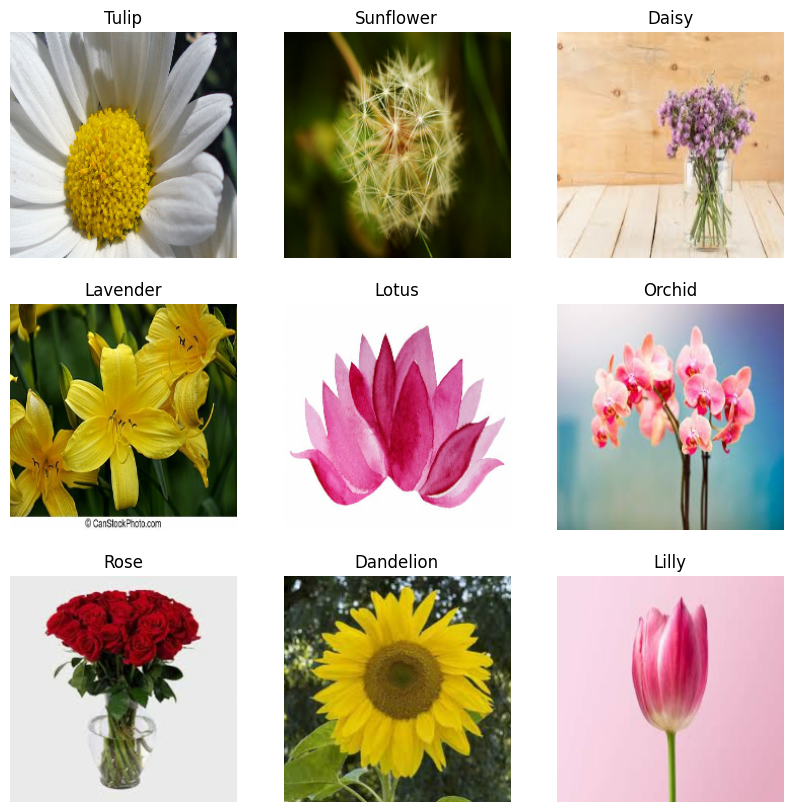

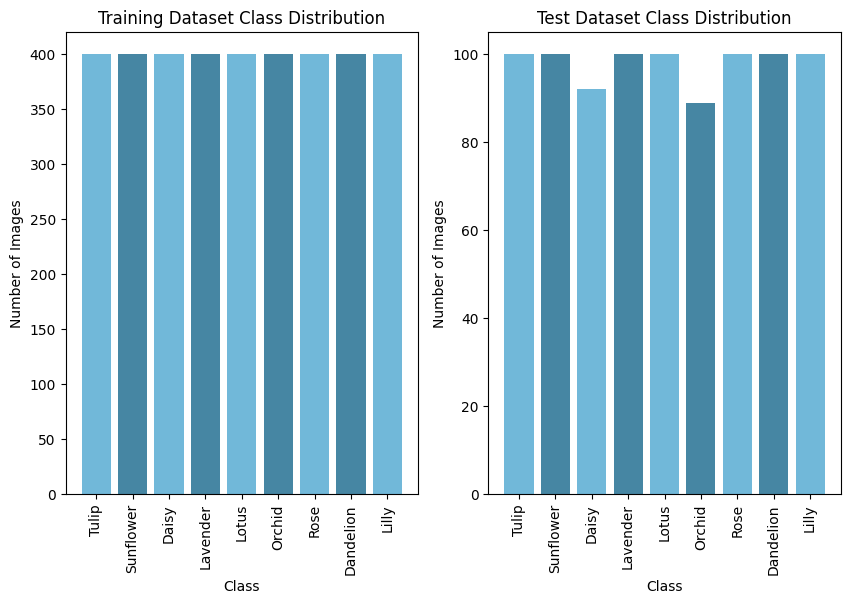

In [ ]:
# Data visualisation

# Displaying sample images from the training dataset
images = []
for img_batch, label_batch in train_ds:
    images.extend(img_batch.numpy())

plt.figure(figsize=(10, 10))
for i in range(NB_CLASSES):
    ax = plt.subplot(3, 3, i + 1)
    ax.imshow(images[i * 400])
    ax.set_title(class_names[i])
    ax.set_axis_off()

plt.show()

# Visualising class distribution for the training dataset and the testing dataset
plt.figure(figsize=(10, 6))

class_distribution = []
for name in class_names:
    class_dir = os.path.join(train_dir, name)
    class_distribution.append(len(os.listdir(class_dir)))

ax = plt.subplot(1, 2, 1)
ax.bar(class_names, class_distribution, color=['#71b8d9', '#4686a3'])
ax.set_title('Training Dataset Class Distribution')
ax.set_xlabel('Class')
ax.set_ylabel('Number of Images')
ax.tick_params(axis='x', labelrotation=90)

class_distribution = []
for name in class_names:
    class_dir = os.path.join(test_dir, name)
    class_distribution.append(len(os.listdir(class_dir)))

ax = plt.subplot(1, 2, 2)
ax.bar(class_names, class_distribution, color=['#71b8d9', '#4686a3'])
ax.set_title('Test Dataset Class Distribution')
ax.set_xlabel('Class')
ax.set_ylabel('Number of Images')
ax.tick_params(axis='x', labelrotation=90)

### Data correlation and feature engineering


CNN that we have not studied: FCN

In [ ]:
import tensorflow as tf
import numpy as np
from collections import namedtuple

# Hyperparameter, could directly be used to adapt values in architecture
ConvLayer = namedtuple('ConvLayer', ['stride', 'kernel_size', 'padding'])
cnn_structure = [
    ConvLayer(stride=1, kernel_size=3, padding=0)
]

def FCN(len_classes = 5, dropout_rate=0.2):

  #Input layer
  input = tf.keras.layers.Input(shape=(None,None,3))

  #Conv block
  x = tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, strides = 1)(input)
  x = tf.keras.layers.Dropout(dropout_rate)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)

  #This decreases the height and width of our input image.
  #In order to find the minimum usable image size, we can repeatedly stack these convolution blocks.
  # QUESTION ELLA: wouldn't it be the other way around - we wanted to stack multiple convolution blocks and thus we have a minimum usable image size?

  #You can also use dense layers by uncommenting this line, but it requires a bit of extra work to get running on the image
  #x = tf.keras.layers.GlobalMaxPooling2D()(x)

  #Dense FCL 1
  #x = tf.keras.layers.Dropout(dropout_rate)(x)
  #x = tf.keras.layers.BatchNormalization()(x)
  #x = tf.layers.Dense(units=64)(x)
  #x = tf.keras.layers.Activation('relu')(x)

  #Fully Connected Layer 1
  x = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1)(input)
  x = tf.keras.layers.Dropout(dropout_rate)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)

  #Dense FCL 2
  #x = tf.keras.layers.Dropout(dropout_rate)(x)
  #x = tf.keras.layers.BatchNormalization()(x)
  #x = tf.layers.Dense(units=len_classes)(x)
  #predictions = tf.keras.layers.Activation('softmax')(x)

  #Fully Connected Layer 2
  x = tf.keras.layers.Conv2D(filters = len_classes, kernel_size = 1, strides = 1)(input)
  x = tf.keras.layers.Dropout(dropout_rate)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.GlobalMaxPooling2D()(x)
  x = tf.keras.layers.Activation('relu')(x)
  predictions = tf.keras.layers.Activation('softmax')(x)

  model = tf.keras.Model(inputs=input, outputs=predictions)
  print(model.summary())
  return model

'''def construct_image_batch(image_group, BATCH_SIZE):
  #Get our max image shape
  max_shape = tuple(max(image.shape[x] for image in image_group) for x in range(3))

  #Make an image batch object
  image_batch = np.zeroes((BATCH_SIZE,) + max_shape, dtype = 'float32')

  #Copy images to upper left part of image batch
  for image_index, image in enumerate(image_group):
    image_batch[image_index, :image.shape[0], :image.shape[1], :image.shape[2]] = image

  return image_batch'''

def train(model, train_generator, val_generator, epochs):
  #Compiling our model
  model.compile(optimizer=tf.keras.optimizers.Lion(learning_rate=0.0001),
                loss = 'categorical_crossentropy',
                metrics=['accuracy'])

  #Storing the model
  path = './snapshots'
  os.makedirs(path, exist_ok=True)
  model_path = os.path.join(path, 'model_epoch_{epoch:02d}_loss_{loss:.2f}_accuracy__{accuracy:.2f}_val_loss_{val_loss:.2f}_val_accuracy_{val_accuracy:.2f}.keras')

  history = model.fit(train_generator,
                                steps_per_epoch = len(train_generator),
                                epochs = epochs,
                                callbacks = [tf.keras.callbacks.ModelCheckpoint(model_path, monitor = 'val_loss', save_best_only=True, verbose = 1)],
                                validation_data = val_generator,
                                validation_steps = len(val_generator))
  return history

def export_model(input, export_path):
  #A method that takes a .h5 file and saves it for us
  tf.keras.backend.set_learning_phase(0) #Ignore dropout at inference point!
  model = tf.keras.models.load_model(input)
  model.save(export_path, save_format = 'tf')

# Determines minimum needed shape of an image to be processed by the network correctly
# Based on the formula to calculate the output of a single convolutional layer,
# given here: https://cs231n.github.io/convolutional-networks/#conv
# Output Shape = (W-F+2P)/S+1
# where
#   W...Shape of the input
#   F...Receptive field size (equivalent to kernel size)
#   S...Stride
# With known minimum output (which is 1x1) of all convolutional layers before
# 1x1 convolution, minimum input shapes for data can be determined
# args: cnn_structure: List of convolutions with kernel size (receptive field size), stride and padding
def minimum_input_size(cnn_structure):
  output = 1  # Reduction to consideration of only one dimension, since final minimum output is 1x1xFilter size, filter size is predetermined and both other dimensions will be treated equally
  for cnn in reversed(cnn_structure):
    min_in = cnn.stride*(output-1)+cnn.kernel_size-2*cnn.padding
    output = min_in
  return output

In [ ]:
import os
import numpy as np
import cv2
from sklearn import preprocessing
import tensorflow as tf
import warnings

# Generator provides train method continuously with data, structured in batches
# Thus, not all data at once has to be stored in memory, but only one batch
# at a time. It also offers more dynamical processing of the data, which can
# be done on the fly per batch.
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, DATASET_PATH, BATCH_SIZE=32, shuffle_images=True, image_min_side=24, max_shape = (24, 24, 3)):
    """ Initialize Generator object.

    Args
        DATASET_PATH           : Path to folder containing individual folders named by their class names
        BATCH_SIZE             : The size of the batches to generate.
        shuffle_images         : If True, shuffles the images read from the DATASET_PATH
        image_min_side         : After resizing the minimum side of an image is equal to image_min_side.
    """

    self.batch_size = BATCH_SIZE
    self.shuffle_images = shuffle_images
    self.image_min_side = image_min_side
    self.load_image_paths_labels(DATASET_PATH)
    self.create_image_groups()

    # USED FOR RESCALING TO ENSURE COMMON SHAPE ACROSS BATCHES
    self.max_shape = max_shape
    if max_shape[0]<image_min_side:
      warnings.warn('Defined common image height falls short of the minimum. Will be set to the minimum.')
      max_shape = (image_min_side, max_shape[1], max_shape[2])
    if max_shape[1]<image_min_side:
      warnings.warn('Defined common image width falls short of the minimum. Will be set to the minimum.')
      max_shape = (max_shape[0], image_min_side, max_shape[2])

  # Creates list of all paths to the input images and of the corresponding
  # labels
  def load_image_paths_labels(self, DATASET_PATH):
    classes = os.listdir(DATASET_PATH)
    lb = preprocessing.LabelBinarizer()
    lb.fit(classes)  # Binarization of categorical output data

    self.image_paths = []
    self.image_labels = []
    for class_name in classes:
        class_path = os.path.join(DATASET_PATH, class_name)
        for image_file_name in os.listdir(class_path):
            self.image_paths.append(os.path.join(class_path, image_file_name))
            self.image_labels.append(class_name)

    self.image_labels = np.array(lb.transform(self.image_labels), dtype='float32')

    assert len(self.image_paths) == len(self.image_labels)

  # Used to assign batches that can be loaded separately
  def create_image_groups(self):
    if self.shuffle_images:
        # Randomly shuffle dataset
        seed = 4321  # Making randomness reproducible
        np.random.seed(seed)
        np.random.shuffle(self.image_paths)
        np.random.seed(seed)
        np.random.shuffle(self.image_labels)

    # Divide image_paths and image_labels into the same groups of BATCH_SIZE
    self.image_groups = [[self.image_paths[x % len(self.image_paths)] for x in range(i, i + self.batch_size)]
                          for i in range(0, len(self.image_paths), self.batch_size)]
    self.label_groups = [[self.image_labels[x % len(self.image_labels)] for x in range(i, i + self.batch_size)]
                          for i in range(0, len(self.image_labels), self.batch_size)]

  # Used to ensure the minimum size of an image input, which is determined by
  # the network structure
  # Determination if smaller side of the image is smaller than the minimum
  # If it is, this is the side that gets enlarged to meet the minimum criterion
  # and the second side will get adapted accordingly to remain the aspect ratio
  def resize_image(self, img, min_side_len):
    h, w, c = img.shape

    if min(h, w) < min_side_len:
        im_scale = float(min_side_len) / h if h < w else float(min_side_len) / w
    else:
        im_scale = 1.

    # USED FOR RESCALING TO ENSURE COMMON SHAPE ACROSS BATCHES
    if h*im_scale > self.max_shape[0]:
        im_scale = self.max_shape[0]/h  # This can never increase the im_scale compared to before
    if w*im_scale > self.max_shape[1]:
        im_scale = self.max_shape[1]/w  # This can never increase the im_scale compared to before

    new_h = int(h * im_scale)
    new_w = int(w * im_scale)

    re_im = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
    return re_im, new_h / h, new_w / w

  # Read all images of one prespecified group from file
  def load_images(self, image_group):
    images = []
    for image_path in image_group:
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img, rh, rw = self.resize_image(img, self.image_min_side)
        images.append(img)

    return images

  # All images of one batch get a zero-padding to the same shape, which is the
  # maximum shape of that batch
  def construct_image_batch(self, image_group):
    # get the max image shape -> OUTCOMMENTED TO ENSURE COMMON SHAPE ACROSS ALL BATCHES
    #max_shape = tuple(max(image.shape[x] for image in image_group) for x in range(3))
    # USED TO ENSURE COMMON SHAPE ACROSS BATCHES
    max_shape = self.max_shape

    print("Max Shape: ", str(max_shape))

    # construct an image batch object
    image_batch = np.zeros((self.batch_size,) + max_shape, dtype='float32')

    print(f"Batch shape: {image_batch.shape}")
    # copy all images to the upper left part of the image batch object
    for image_index, image in enumerate(image_group):
        image_batch[image_index, :image.shape[0], :image.shape[1], :image.shape[2]] = image

    return image_batch

  def __len__(self):
    """
    Number of batches for generator.
    """
    return len(self.image_groups)

  # Produces the data in batches that get fed into the training method
  def __getitem__(self, index):
    """
    Keras sequence method for generating batches.
    """
    image_group = self.image_groups[index]
    label_group = self.label_groups[index]
    images = self.load_images(image_group)
    image_batch = self.construct_image_batch(images)

    return np.array(image_batch), np.array(label_group)

In [ ]:
model = FCN(len_classes=NB_CLASSES, dropout_rate=0.2)
image_min_side = image_min_side = minimum_input_size(cnn_structure)

# determine the maximum of the first couple of batches to use in both training and testing
# TODO: actually do this for the first couple of batches and not just the first element of the first batch
max_shape_first_batches = (0,0,0)
train_ds.batch(batch_size)
for batch, labels in train_ds:
  for image in batch:
    print(batch.shape)
    print(image.shape)
    max_shape_first_batches = tuple(max(image.shape[x], max_shape_first_batches[x]) for x in range(3))
    break
  break

train_generator = DataGenerator(train_dir, batch_size, shuffle_images = True, image_min_side = image_min_side, max_shape = max_shape_first_batches)
val_generator = DataGenerator(test_dir, batch_size, shuffle_images=True, image_min_side=image_min_side, max_shape = max_shape_first_batches)
epochs = 50
history = train(model, train_generator, val_generator, epochs=epochs)

**Uncovered architecture - Fully Connected Network**

A fully connected network is built by taking a regular VGG-16 model, then adding a number of Fully Connected layers on top of it. Each tier of layers upgrades the model, going from FCN 32 to 16 to 8.

IMAGE PROCESSING: The FCN works by taking an image, then downsizing it and getting the outlines. The downsized image with the outlines (called a 'label') will be deconvolutionised to return it to its former size. This is done through 32x upsampling with the first round of Fully Cnneected Layers, giving the FCN-32 its name.

The label output will be rough due to going deep into the layers, so it must then be enhanced using element-wise addition.

This will then be repeated for the FCN-16 and FCN-8 layers, using 16x and 8x unsampling respectively. The label map will get less rough each time, resulting in clearer outlines and colour blocks.

COMPARISON BETWEEN MODELS

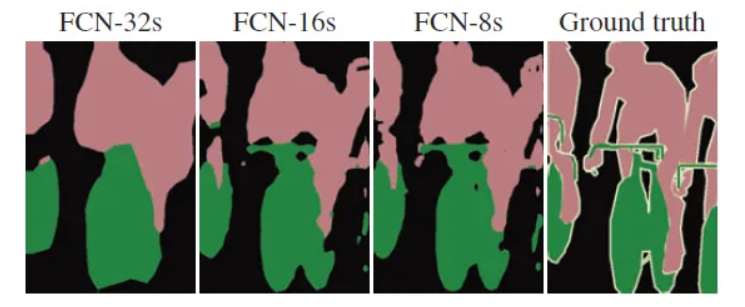

**FCN32**

Below are diagrams representing the architecture of FCN32.

Reference (To be added to the top later on): https://github.com/kevinddchen/Keras-FCN/tree/main

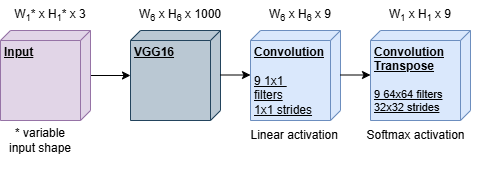

*FCN32*

In [ ]:
#Utility block!

"""
This file contains useful methods for handling image files.
"""

import numpy as np
import tensorflow as tf
import scipy.io # to read .mat files
from PIL import Image # to read image files

PALETTE = np.reshape([
    0, 0, 0, 128, 0, 0, 0, 128, 0, 128, 128, 0, 0, 0, 128, 128, 0, 128, 0, 128,
    128, 128, 128, 128, 64, 0, 0, 192, 0, 0, 64, 128, 0, 192, 128, 0, 64, 0,
    128, 192, 0, 128, 64, 128, 128, 192, 128, 128, 0, 64, 0, 128, 64, 0, 0,
    192, 0, 128, 192, 0, 0, 64, 128, 128, 64, 128, 0, 192, 128, 128, 192, 128,
    64, 64, 0, 192, 64, 0, 64, 192, 0, 192, 192, 0, 64, 64, 128, 192, 64, 128,
    64, 192, 128, 192, 192, 128, 0, 0, 64, 128, 0, 64, 0, 128, 64, 128, 128,
    64, 0, 0, 192, 128, 0, 192, 0, 128, 192, 128, 128, 192, 64, 0, 64, 192, 0,
    64, 64, 128, 64, 192, 128, 64, 64, 0, 192, 192, 0, 192, 64, 128, 192, 192,
    128, 192, 0, 64, 64, 128, 64, 64, 0, 192, 64, 128, 192, 64, 0, 64, 192,
    128, 64, 192, 0, 192, 192, 128, 192, 192, 64, 64, 64, 192, 64, 64, 64, 192,
    64, 192, 192, 64, 64, 64, 192, 192, 64, 192, 64, 192, 192, 192, 192, 192,
    32, 0, 0, 160, 0, 0, 32, 128, 0, 160, 128, 0, 32, 0, 128, 160, 0, 128, 32,
    128, 128, 160, 128, 128, 96, 0, 0, 224, 0, 0, 96, 128, 0, 224, 128, 0, 96,
    0, 128, 224, 0, 128, 96, 128, 128, 224, 128, 128, 32, 64, 0, 160, 64, 0,
    32, 192, 0, 160, 192, 0, 32, 64, 128, 160, 64, 128, 32, 192, 128, 160, 192,
    128, 96, 64, 0, 224, 64, 0, 96, 192, 0, 224, 192, 0, 96, 64, 128, 224, 64,
    128, 96, 192, 128, 224, 192, 128, 32, 0, 64, 160, 0, 64, 32, 128, 64, 160,
    128, 64, 32, 0, 192, 160, 0, 192, 32, 128, 192, 160, 128, 192, 96, 0, 64,
    224, 0, 64, 96, 128, 64, 224, 128, 64, 96, 0, 192, 224, 0, 192, 96, 128,
    192, 224, 128, 192, 32, 64, 64, 160, 64, 64, 32, 192, 64, 160, 192, 64, 32,
    64, 192, 160, 64, 192, 32, 192, 192, 160, 192, 192, 96, 64, 64, 224, 64,
    64, 96, 192, 64, 224, 192, 64, 96, 64, 192, 224, 64, 192, 96, 192, 192,
    224, 192, 192, 0, 32, 0, 128, 32, 0, 0, 160, 0, 128, 160, 0, 0, 32, 128,
    128, 32, 128, 0, 160, 128, 128, 160, 128, 64, 32, 0, 192, 32, 0, 64, 160,
    0, 192, 160, 0, 64, 32, 128, 192, 32, 128, 64, 160, 128, 192, 160, 128, 0,
    96, 0, 128, 96, 0, 0, 224, 0, 128, 224, 0, 0, 96, 128, 128, 96, 128, 0,
    224, 128, 128, 224, 128, 64, 96, 0, 192, 96, 0, 64, 224, 0, 192, 224, 0,
    64, 96, 128, 192, 96, 128, 64, 224, 128, 192, 224, 128, 0, 32, 64, 128, 32,
    64, 0, 160, 64, 128, 160, 64, 0, 32, 192, 128, 32, 192, 0, 160, 192, 128,
    160, 192, 64, 32, 64, 192, 32, 64, 64, 160, 64, 192, 160, 64, 64, 32, 192,
    192, 32, 192, 64, 160, 192, 192, 160, 192, 0, 96, 64, 128, 96, 64, 0, 224,
    64, 128, 224, 64, 0, 96, 192, 128, 96, 192, 0, 224, 192, 128, 224, 192, 64,
    96, 64, 192, 96, 64, 64, 224, 64, 192, 224, 64, 64, 96, 192, 192, 96, 192,
    64, 224, 192, 192, 224, 192, 32, 32, 0, 160, 32, 0, 32, 160, 0, 160, 160,
    0, 32, 32, 128, 160, 32, 128, 32, 160, 128, 160, 160, 128, 96, 32, 0, 224,
    32, 0, 96, 160, 0, 224, 160, 0, 96, 32, 128, 224, 32, 128, 96, 160, 128,
    224, 160, 128, 32, 96, 0, 160, 96, 0, 32, 224, 0, 160, 224, 0, 32, 96, 128,
    160, 96, 128, 32, 224, 128, 160, 224, 128, 96, 96, 0, 224, 96, 0, 96, 224,
    0, 224, 224, 0, 96, 96, 128, 224, 96, 128, 96, 224, 128, 224, 224, 128, 32,
    32, 64, 160, 32, 64, 32, 160, 64, 160, 160, 64, 32, 32, 192, 160, 32, 192,
    32, 160, 192, 160, 160, 192, 96, 32, 64, 224, 32, 64, 96, 160, 64, 224,
    160, 64, 96, 32, 192, 224, 32, 192, 96, 160, 192, 224, 160, 192, 32, 96,
    64, 160, 96, 64, 32, 224, 64, 160, 224, 64, 32, 96, 192, 160, 96, 192, 32,
    224, 192, 160, 224, 192, 96, 96, 64, 224, 96, 64, 96, 224, 64, 224, 224,
    64, 96, 96, 192, 224, 96, 192, 96, 224, 192, 224, 224, 192], (-1, 3))



def get_image(path):
    '''Retrieve image as array of RGB values from .jpg file.

    Args:
      path (string): Path to .jpg file

    Returns:
      (array<np.uint8>): RGB values for each pixel. Shape=(height, width, 3)
    '''
    jpg = Image.open(path).convert('RGB')
    return np.array(jpg)



def get_label_mat(path):
    '''Retrieve class labels for each pixel from Berkeley SBD .mat file.

    Args:
      path (string): Path to .mat file

    Returns:
      (array<np.uint8>): Class as an integer in [0, 20] for each pixel. Shape=(height, width, 1)
    '''
    mat = scipy.io.loadmat(path)
    arr = mat['GTcls']['Segmentation'].item(0,0) # this is how segmentation is stored
    return arr[..., None]



def get_label_png(path):
    '''Retrieve class labels for each pixel from Pascal VOC .png file.

    Args:
      path (string): Path to .png file

    Returns:
      (array<np.uint8>): Class as an integer in [-1, 20], where -1 is boundary, for each pixel. Shape=(height, width, 1)
    '''
    png = Image.open(path) # image is saved as palettised png. OpenCV cannot load without converting.
    arr = np.array(png)
    return arr[..., None]



def label_to_image(label, palette=PALETTE):
    '''Converts class labels to color image using a palette.

    Args:
      label (array<np.uint8>): Class labels for each pixel. Shape=(height, width, 1)
      palette (array<np.uint8>): RGB values for each class. Shape=(255, 3)

    Returns:
      (array<np.uint8>): RGB values for each pixel. Shape=(height, width, 3)
    '''
    return palette[label[..., 0]].astype(np.uint8)



def label_to_onehot(label, num_classes=21):
    '''Converts class labels to its one-hot encoding.

    Args:
      label (array<np.uint8>): Class labels for each pixel. Shape=(height, width, 1)

    Returns:
      (array<np.uint8>): One-hot encoding of class labels for each pixel. Boundary is ignored.
        Shape=(height, width, num_classes)
    '''
    return (np.arange(21) == label).astype(np.uint8)



def onehot_to_label(arr):
    '''Opposite of label_to_onehot().'''
    arr = np.argmax(arr, axis=-1).astype(np.uint8)
    return arr[..., None]

def get_example(image, label):
    '''Given image and label, produce a tf Example that can be written to a .tfrecords file.

    Args:
      image (array<np.uint8>): Shape=(height, width, 3)
      label (array<np.uint8>): Shape=(height, width, 1)

    Returns:
      (tf Example)
    '''
    ## Usage:
    #with tf.io.TFRecordWriter(PATH_TO_TFRECORDS) as writer:
    #    writer.write(get_example(image, label).SerializeToString())
    feature = {
        'height': tf.train.Feature(int64_list=tf.train.Int64List(value=[image.shape[0]])),
        'width': tf.train.Feature(int64_list=tf.train.Int64List(value=[image.shape[1]])),
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image.tobytes()])),
        'label': tf.train.Feature(bytes_list=tf.train.BytesList(value=[label.tobytes()]))
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))



def parse_example(example):
    '''Parse tf Example to obtain image and label.

    Args:
      example (tf Example)

    Returns:
      image (array<np.uint8>): Shape=(height, width, 3)
      label (array<np.uint8>): Shape=(height, width, 1)
    '''
    ## Usage:
    #dataset = tf.data.TFRecordDataset(PATH_TO_TFRECORDS).map(parse_example)
    feature_description = {
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.string),
    }
    dct = tf.io.parse_single_example(example, feature_description)
    height = dct['height']
    width = dct['width']
    image = tf.reshape(tf.io.decode_raw(dct['image'], out_type=tf.uint8), (height, width, 3))
    label = tf.reshape(tf.io.decode_raw(dct['label'], out_type=tf.uint8), (height, width, 1))
    return image, label

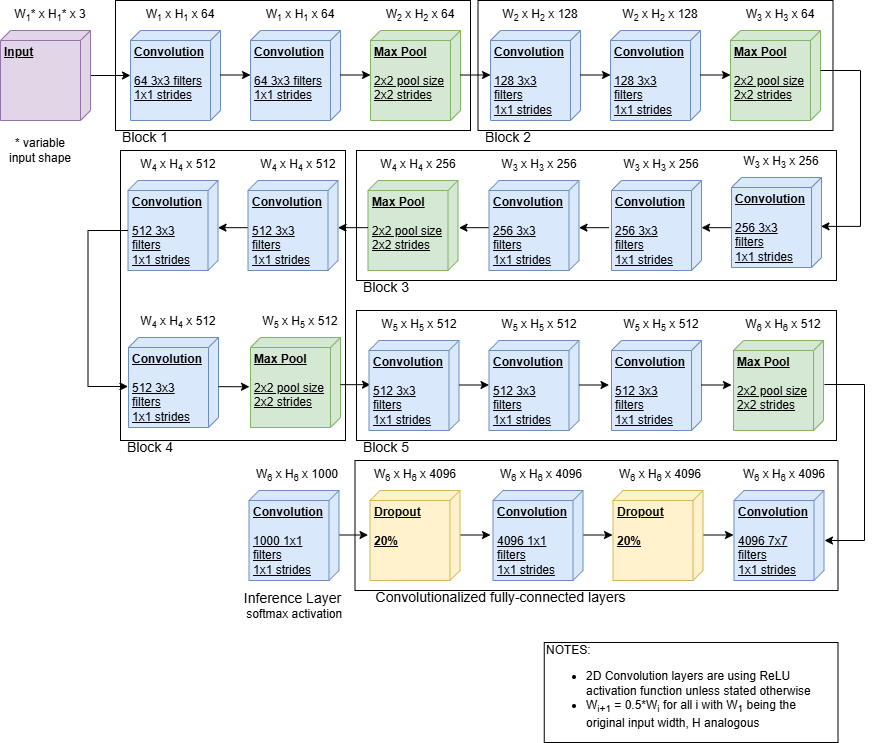

*VGG16*

In [ ]:
import  numpy as np
import tensorflow as tf
import tensorflow.keras as keras

#A method to make a VGG-16 FCN model using Keras
def vgg16(l2, dropout):
  #Params: l2 strength and Dropout rate, for regularisations

  input_layer = keras.Input(shape=(None, None, 3), name='input')

  #Preprocessing
  x = keras.layers.Lambda(tf.keras.applications.vgg16.preprocess_input, name='preprocessing')(input_layer)

  #Convolution Block 1: Filter size: 64, Kernel Size: 3x3, Stride = 1
  x = keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=keras.regularizers.L2(l2=l2), name='block1_conv1')(x)
  x = keras.layers.Conv2D(filters=64, kernel_size=3,  strides=(1,1), padding='same', activation='relu', kernel_regularizer=keras.regularizers.L2(l2=l2), name='block1_conv2')(x)
  x = keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid', name='block1_pool')(x)

  #Convolution Block 2: Filter size: 128, Kernel Size: 3x3, Stride = 1
  x = keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=keras.regularizers.L2(l2=l2), name='block2_conv1')(x)
  x = keras.layers.Conv2D(filters=128, kernel_size=3,  strides=(1,1), padding='same', activation='relu', kernel_regularizer=keras.regularizers.L2(l2=l2), name='block2_conv2')(x)
  x = keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid', name='block2_pool')(x)

  #Convolution Block 3: Filter size: 256, Kernel Size: 3x3, Stride = 1
  x = keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=keras.regularizers.L2(l2=l2), name='block3_conv1')(x)
  x = keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=keras.regularizers.L2(l2=l2), name='block3_conv2')(x)
  x = keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=keras.regularizers.L2(l2=l2), name='block3_conv3')(x)
  x = keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid', name='block3_pool')(x)

  #Convolution Block 4: Filter size: 512, Kernel Size: 3x3, Stride = 1
  x = keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=keras.regularizers.L2(l2=l2), name='block4_conv1')(x)
  x = keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=keras.regularizers.L2(l2=l2), name='block4_conv2')(x)
  x = keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=keras.regularizers.L2(l2=l2), name='block4_conv3')(x)
  x = keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid', name='block4_pool')(x)

  #Convolution Block 4: Filter size: 512, Kernel Size: 3x3, Stride = 1
  x = keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=keras.regularizers.L2(l2=l2), name='block5_conv1')(x)
  x = keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=keras.regularizers.L2(l2=l2), name='block5_conv2')(x)
  x = keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=keras.regularizers.L2(l2=l2), name='block5_conv3')(x)
  x = keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid', name='block5_pool')(x)

  #Convolutionized fully-connected layers

  #Layer 6: Filter size: 4096, Kernel size = 7x7, Stride = 1
  x = keras.layers.Conv2D(filters=4096, kernel_size=(7,7), strides=(1,1), padding='same', activation='relu',kernel_regularizer=keras.regularizers.L2(l2=l2), name='conv6')(x)
  x = keras.layers.Dropout(rate=dropout, name='drop6')(x)

  #Layer 7: Filter size: 4096, Kernel size = 1x1, Stride = 1
  x = keras.layers.Conv2D(filters=4096, kernel_size=(1,1), strides=(1,1), padding='same', activation='relu', kernel_regularizer=keras.regularizers.L2(l2=l2), name='conv7')(x)
  x = keras.layers.Dropout(rate=dropout, name='drop7')(x)

  #Inference layer (1000 filters, 1x1 Kernel, Stride of 1)
  x = keras.layers.Conv2D(filters=1000, kernel_size=(1,1), strides=(1,1), padding='same', activation='softmax', name='pred')(x)
  return keras.Model(input_layer, x)

#Now that we have our VGG model, we can add extra layers to build up to the FCN-8
def fcn32(vgg16, l2):
    '''32x upsampled FCN.

    Args:
      vgg16 (keras Model): VGG16 model to build upon
      l2 (float): L2 regularization strength

    Returns:
      (keras Model)
    '''

    #Making new layers and adding them onto our VGG-16
    x = keras.layers.Conv2D(filters=9, kernel_size=(1,1), strides=(1,1), padding='same', activation='linear', kernel_regularizer=keras.regularizers.L2(l2=l2),
                            name='score7')(vgg16.get_layer('drop7').output)
    x = keras.layers.Conv2DTranspose(filters=9, kernel_size=(64,64), strides=(32,32),
                                     padding='same', use_bias=False, activation='softmax',
                                     kernel_initializer=BilinearInitializer(),
                                     kernel_regularizer=keras.regularizers.L2(l2=l2),
                                     name='fcn32')(x)
    return keras.Model(vgg16.input, x)

def fcn16(vgg16, fcn32, l2=0):
    '''16x upsampled FCN.

    Args:
      vgg16 (keras Model): VGG16 model to build upon
      fcn32 (keras Model): FCN32 model to build upon
      l2 (float): L2 regularization strength

    Returns:
      (keras Model)
    '''
    x = keras.layers.Conv2DTranspose(filters=9, kernel_size=(4,4), strides=(2,2),
                                     padding='same', use_bias=False, activation='linear',
                                     kernel_initializer=BilinearInitializer(),
                                     kernel_regularizer=keras.regularizers.L2(l2=l2),
                                     name='score7_upsample')(fcn32.get_layer('score7').output)
    y = keras.layers.Conv2D(filters=9, kernel_size=(1,1), strides=(1,1), padding='same', activation='linear',
                            kernel_initializer=keras.initializers.Zeros(),
                            kernel_regularizer=keras.regularizers.L2(l2=l2),
                            name='score4')(vgg16.get_layer('block4_pool').output)
    x = keras.layers.Add(name='skip4')([x, y])
    x = keras.layers.Conv2DTranspose(filters=9, kernel_size=(32,32), strides=(16, 16),
                                     padding='same', use_bias=False, activation='softmax',
                                     kernel_initializer=BilinearInitializer(),
                                     kernel_regularizer=keras.regularizers.L2(l2=l2),
                                     name='fcn16')(x)
    return keras.Model(fcn32.input, x)


def fcn8(vgg16, fcn16, l2=0):
    '''8x upsampled FCN.

    Args:
      vgg16 (keras Model): VGG16 model to build upon
      fcn16 (keras Model): FCN16 model to build upon
      l2 (float): L2 regularization strength

    Returns:
      (keras Model)
    '''
    x = keras.layers.Conv2DTranspose(filters=9, kernel_size=(4,4), strides=(2,2),
                                     padding='same', use_bias=False, activation='linear',
                                     kernel_initializer=BilinearInitializer(),
                                     kernel_regularizer=keras.regularizers.L2(l2=l2),
                                     name='skip4_upsample')(fcn16.get_layer('skip4').output)
    y = keras.layers.Conv2D(filters=9, kernel_size=(1,1), strides=(1,1), padding='same', activation='linear',
                            kernel_initializer=keras.initializers.Zeros(),
                            kernel_regularizer=keras.regularizers.L2(l2=l2),
                            name='score3')(vgg16.get_layer('block3_pool').output)
    x = keras.layers.Add(name='skip3')([x, y])
    x = keras.layers.Conv2DTranspose(filters=9, kernel_size=(16,16), strides=(8,8),
                                     padding='same', use_bias=False, activation='softmax',
                                     kernel_initializer=BilinearInitializer(),
                                     kernel_regularizer=keras.regularizers.L2(l2=l2),
                                     name='fcn8')(x)
    return keras.Model(fcn16.input, x)


## ================
## Misc functions for training
## ================

class BilinearInitializer(keras.initializers.Initializer):
    '''Initializer for Conv2DTranspose to perform bilinear interpolation on each channel.'''
    def __call__(self, shape, dtype=None, **kwargs):
        kernel_size, _, filters, _ = shape
        arr = np.zeros((kernel_size, kernel_size, filters, filters))
        ## make filter that performs bilinear interpolation through Conv2DTranspose
        upscale_factor = (kernel_size+1)//2
        if kernel_size % 2 == 1:
            center = upscale_factor - 1
        else:
            center = upscale_factor - 0.5
        og = np.ogrid[:kernel_size, :kernel_size]
        kernel = (1-np.abs(og[0]-center)/upscale_factor) * \
                 (1-np.abs(og[1]-center)/upscale_factor) # kernel shape is (kernel_size, kernel_size)
        for i in range(filters):
            arr[..., i, i] = kernel
        return tf.convert_to_tensor(arr, dtype=dtype)



def crossentropy(y_true, y_pred_onehot):
    '''Custom cross-entropy to handle borders (class = -1).'''
    n_valid = tf.math.reduce_sum(tf.cast(y_true != 255, tf.float32))
    y_true_onehot = tf.cast(np.arange(21) == y_true, tf.float32)
    return tf.reduce_sum(-y_true_onehot * tf.math.log(y_pred_onehot + 1e-7)) / n_valid

def pixelacc(y_true, y_pred_onehot):
    '''Custom pixel accuracy to handle borders (class = -1).'''
    n_valid = tf.math.reduce_sum(tf.cast(y_true != 255, tf.float32))
    y_true = tf.cast(y_true, tf.int32)[..., 0]
    y_pred = tf.argmax(y_pred_onehot, axis=-1, output_type=tf.int32)
    return tf.reduce_sum(tf.cast(y_true == y_pred, tf.float32)) / n_valid



class MyMeanIoU(keras.metrics.MeanIoU):
    '''Custom meanIoU to handle borders (class = -1).'''
    def update_state(self, y_true, y_pred_onehot, sample_weight=None):
        y_pred = tf.argmax(y_pred_onehot, axis=-1)
        ## add 1 so boundary class=0
        y_true = tf.cast(y_true+1, self._dtype)
        y_pred = tf.cast(y_pred+1, self._dtype)
        ## Flatten the input if its rank > 1.
        if y_pred.shape.ndims > 1:
            y_pred = tf.reshape(y_pred, [-1])
        if y_true.shape.ndims > 1:
            y_true = tf.reshape(y_true, [-1])
        ## calculate confusion matrix with one extra class
        current_cm = tf.math.confusion_matrix(
            y_true,
            y_pred,
            self.num_classes+1,
            weights=sample_weight,
            dtype=self._dtype)
        return self.total_cm.assign_add(current_cm[1:, 1:]) # remove boundary

In [ ]:
#This code block sets up a drive to store models in the Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/FCN')

Mounted at /content/drive


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/FCN'

In [ ]:
#Make a VGG model
base_model = vgg16(l2=1e-6, dropout=0.2)

NameError: name 'vgg16' is not defined

In [ ]:
#Load VGG-16 Image weights
vgg16 = keras.applications.vgg16.VGG16(weights='imagenet')
weight_list = vgg16.get_weights()
weight_list[26] = weight_list[26].reshape(7, 7, 512, 4096)
weight_list[28] = weight_list[28].reshape(1, 1, 4096, 4096)
weight_list[30] = weight_list[30].reshape(1, 1, 4096, 1000)
base_model.set_weights(weight_list)
del weight_list

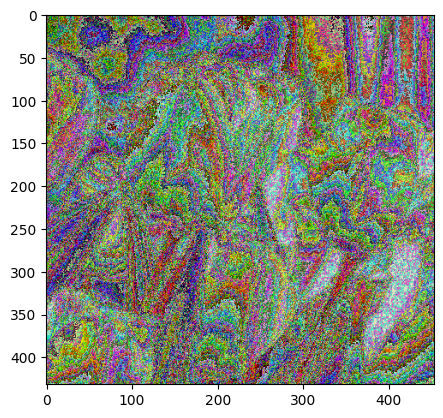

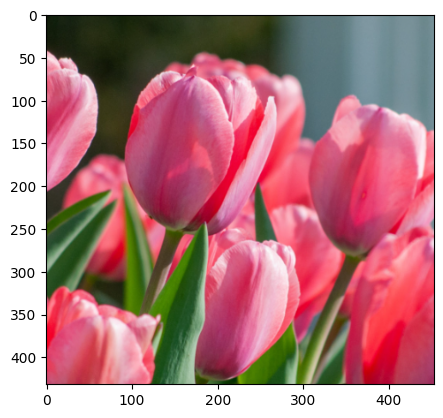

Top three guesses with probabilities:
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
309
301
310


In [ ]:
#Training the model

img = get_image('/content/tuliptest.png')
plt.imshow(label_to_image(img))
plt.figure()
plt.imshow(img)
plt.show()

print('Top three guesses with probabilities:')
probs = base_model.predict(img[None])[0, 3, 3] # pick the central prediction from 7 x 7 square
pred = np.argsort(probs)[::-1]
for i in range(3):
    c = pred[i]
    print(c)
    #print("{0:s} (p={1:.3f})".format(class_names[c], probs[c]))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Freezable layers for experimentation!
fcn32 = fcn32(base_model, 1e-6)
# fcn32.get_layer('block1_conv1').trainable=False
# fcn32.get_layer('block1_conv2').trainable=False
# fcn32.get_layer('block2_conv1').trainable=False
# fcn32.get_layer('block2_conv2').trainable=False
# fcn32.get_layer('block3_conv1').trainable=False
# fcn32.get_layer('block3_conv2').trainable=False
# fcn32.get_layer('block3_conv3').trainable=False
# fcn32.get_layer('block4_conv1').trainable=False
# fcn32.get_layer('block4_conv2').trainable=False
# fcn32.get_layer('block4_conv3').trainable=False
# freeze upsample layer
fcn32.get_layer('fcn32').trainable=False

In [ ]:
#Load the weights for the FCN32!
fcn32.load_weights('weights/fcn32_25.h5')

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'weights/fcn32_25.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
#Bring in the FCN-16, with custom-freezable layers
fcn16 = fcn16(base_model, fcn32, l2=1e-6)

# fcn16.get_layer('block4_conv1').trainable=True
# fcn16.get_layer('block4_conv2').trainable=True
# fcn16.get_layer('block4_conv3').trainable=True
# freeze upsample layer
fcn16.get_layer('score7_upsample').trainable=False
fcn16.get_layer('fcn16').trainable=False

In [ ]:
#Load our weights for the FCN16!
fcn16.load_weights('weights/fcn16_25.h5')

In [ ]:
#Build up an FCN8 over our FCN16
fcn8 = fcn8(base_model, fcn16, l2=1e-6)
#Custom-freezable layers

# fcn8.get_layer('block1_conv1').trainable=True
# fcn8.get_layer('block1_conv2').trainable=True
# fcn8.get_layer('block2_conv1').trainable=True
# fcn8.get_layer('block2_conv2').trainable=True
# fcn8.get_layer('block3_conv1').trainable=True
# fcn8.get_layer('block3_conv2').trainable=True
# fcn8.get_layer('block3_conv3').trainable=True
# freeze upsample layer
fcn8.get_layer('skip4_upsample').trainable=False
fcn8.get_layer('fcn8').trainable=False

ValueError: Inputs have incompatible shapes. Received shapes (None, None, 9) and (None, None, 21)

In [ ]:
#Load FCN8 weights
fcn8.load_weights('weights/fcn8_25.h5')

Training Blocks

In [ ]:
## Load model
model = fcn32
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ preprocessing (Lambda)               │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv6 (Conv2D)                       │ (None, None, None, 4096)    │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 136,152,917 (519.38 MB)

 Trainable params: 134,346,581 (512.49 MB)

 Non-trainable params: 1,806,336 (6.89 MB)

In [ ]:
#Compile our model
#opt = keras.optimizers.Adam(learning_rate=1e-4)
opt = keras.optimizers.Lamb(learning_rate=1e-4) #The original optimiser funtion here was Adam, but we opted to use Lamb, which is geared towards larger datasets
loss = crossentropy
metrics = [loss,
           pixelacc,
           MyMeanIoU(num_classes=21, name='meanIoU')]
model.compile(optimizer=opt, loss=loss, metrics=metrics)

In [ ]:
import numpy as np
import tensorflow as tf

#Image resizer for preprocessing

#def resize_with_pad(image, label, size=512):
def resize_with_pad(image, label, size=512):
    '''Resize a square while keeping the original aspect ratio, padding with black for the image and boundary
    for the label.

    Args:
      image (array<np.uint8>): RGB values for each pixel. Shape=(height, width, 3)
      label (array<np.uint8>): Class labels for each pixel. Shape=(height, width, 1)
      size (int): length of square

    Returns:
      (array<np.uint8>): Resized image. Shape=(size, size, 3)
      (array<np.uint8>): Resized label. Shape=(size, size, 1)
    '''
    image = tf.image.resize_with_pad(image, size, size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    ## since `resize_with_pad` pads with zeros, use fact that boundary class is -1 to pad with -1 instead.
    #label = tf.image.resize_with_pad(label+1, size, size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)-1
    #return image, label
    return image

In [ ]:
#Split data into training and testing!

train = train_ds.shuffle(1000).unbatch().batch(16)
test = test_ds.shuffle(1000).unbatch().batch(16)

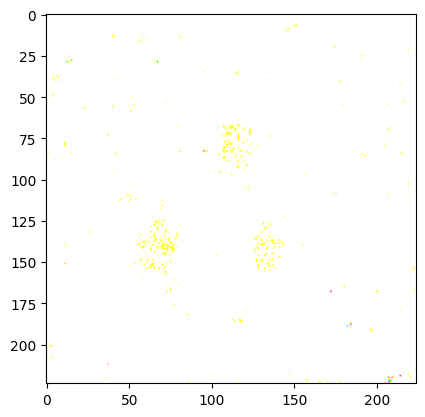

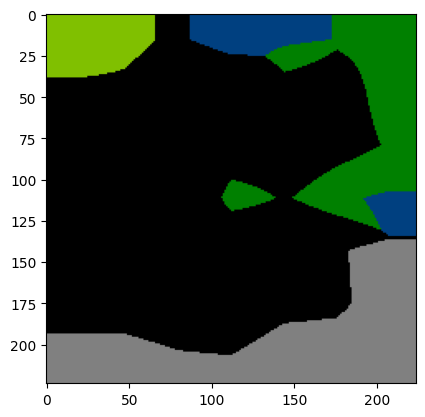

In [ ]:
#Test our model!
for X, y in test.unbatch().shuffle(100).batch(1).take(1):
    plt.figure()
    plt.imshow(X[0])
    plt.show()

    #plt.figure()
    #plt.imshow(label_to_image(y[0]))
    #plt.show()

    plt.figure()
    plt.imshow(label_to_image(onehot_to_label(model(X)[0])))
    plt.show()
    #model.evaluate(X, y)

In [ ]:
## check running GPU
tf.test.gpu_device_name()

''

In [ ]:
history = model.fit(train, epochs=5, validation_data=valid_ds)

Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node confusion_matrix/stack_1 defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-70-804fd38f027f>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 77, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/trainer.py", line 452, in compute_metrics

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/compile_utils.py", line 330, in update_state

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/compile_utils.py", line 17, in update_state

  File "<ipython-input-14-e6bc214df7b4>", line 188, in update_state

Shapes of all inputs must match: values[0].shape = [144] != values[1].shape = [802816]
	 [[{{node confusion_matrix/stack_1}}]] [Op:__inference_one_step_on_iterator_13225]

In [ ]:
## Save weights and metrics

save_weights('weights/fcn32_5.h5')

with open('logs/fcn32_5', 'wb') as f:
    pickle.dump(history.history, f)

Evaluation Blocks

In [ ]:
from PIL import Image
import pickle

In [ ]:
raw_X = get_image('assets/rider.jpg')
raw_y_true = get_label_mat('assets/rider_label.mat')

In [ ]:
X, y_true = resize_with_pad(raw_X, raw_y_true)
y_pred = model(X[None])[0]
_ = evaluate(X[None], y_true[None])

In [ ]:
raw_y_pred = tf.image.resize_with_crop_or_pad(y_pred, raw_y_true.shape[0], raw_y_true.shape[1])
raw_y_pred = utils.onehot_to_label(raw_y_pred)

In [ ]:
plt.figure()
plt.imshow(utils.label_to_image(raw_y_true))
plt.show()

plt.figure()
plt.imshow(utils.label_to_image(raw_y_pred))
plt.show()

In [ ]:
## save pred label
im = Image.fromarray(utils.label_to_image(raw_y_pred))
im.save('assets/fcn32.png')

In [ ]:
## save true label
im = Image.fromarray(utils.label_to_image(raw_y_true))
im.save('assets/rider_label.png')

In [ ]:
## aggregate data if needed
with open('logs/fcn32_5', 'rb') as f:
    h1 = pickle.load(f)
with open('logs/fcn32_10', 'rb') as f:
    h2 = pickle.load(f)
with open('logs/fcn32_15', 'rb') as f:
    h3 = pickle.load(f)
with open('logs/fcn32_20', 'rb') as f:
    h4 = pickle.load(f)
with open('logs/fcn32_25', 'rb') as f:
    h5 = pickle.load(f)

for key in h1:
    h1[key] += h2[key]
    h1[key] += h3[key]
    h1[key] += h4[key]
    h1[key] += h5[key]

with open('logs/fcn32_25x', 'wb') as f:
    pickle.dump(h1, f)

In [ ]:
with open('logs/fcn32_25', 'rb') as f:
    h1 = pickle.load(f)
with open('logs/fcn16_25', 'rb') as f:
    h2 = pickle.load(f)
with open('logs/fcn8_25', 'rb') as f:
    h3 = pickle.load(f)

In [ ]:
plt.plot(range(1,26), h1['val_loss'], '-', color='blue', label='FCN32 validation loss')
plt.plot(range(1,26), h1['loss'], '--', color='blue', label='FCN32 training loss')
plt.plot(range(1,26), h2['val_loss'], '-', color='red', label='FCN16 validation loss')
plt.plot(range(1,26), h2['loss'], '--', color='red', label='FCN16 training loss')
plt.plot(range(1,26), h3['val_loss'], '-', color='green', label='FCN8 validation loss')
plt.plot(range(1,26), h3['loss'], '--', color='green', label='FCN8 training loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(range(1,26), h1['val_meanIoU'], '-', color='blue', label='FCN32 validation meanIoU')
plt.plot(range(1,26), h1['meanIoU'], '--', color='blue', label='FCN32 training meanIoU')
plt.plot(range(1,26), h2['val_meanIoU'], '-', color='red', label='FCN16 validation meanIoU')
plt.plot(range(1,26), h2['meanIoU'], '--', color='red', label='FCN16 training meanIoU')
plt.plot(range(1,26), h3['val_meanIoU'], '-', color='green', label='FCN8 validation meanIoU')
plt.plot(range(1,26), h3['meanIoU'], '--', color='green', label='FCN8 training meanIoU')
plt.legend()
plt.show()

In [ ]:
print('fcn32 pixel acc: {0:.3f}'.format(h1['val_pixelacc'][-1]))
print('fcn16 pixel acc: {0:.3f}'.format(h2['val_pixelacc'][-1]))
print('fcn8 pixel acc: {0:.3f}'.format(h3['val_pixelacc'][-1]))
print()
print('fcn32 val meanIoU: {0:.3f}'.format(h1['val_meanIoU'][-1]))
print('fcn16 val meanIoU: {0:.3f}'.format(h2['val_meanIoU'][-1]))
print('fcn8 val meanIoU: {0:.3f}'.format(h3['val_meanIoU'][-1]))

Attempt 2: ResNext

In [ ]:
!pip install keras_applications

from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import keras
import warnings
import tensorflow as tf
import keras.backend as K
from keras.models import Model
from keras.layers import Input
from keras.regularizers import l2
from keras.layers import Activation
from keras.layers import Dense, Lambda
from keras.utils import get_file

from tensorflow.keras.utils import plot_model
from keras.layers import Conv2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPool2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import concatenate, add
from keras.utils import get_source_inputs
from tensorflow.keras.layers import BatchNormalization
#from tensorflow.keras.utils import convert_all_kernels_in_model
from keras_applications.imagenet_utils import _obtain_input_shape

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.4 MB/s eta 0:00:00


In [ ]:
# Building the ResNext Model Architecture

CIFAR_TH_WEIGHTS_PATH = ''
CIFAR_TF_WEIGHTS_PATH = ''
CIFAR_TH_WEIGHTS_PATH_NO_TOP = ''
CIFAR_TF_WEIGHTS_PATH_NO_TOP = ''

IMAGENET_TH_WEIGHTS_PATH = ''
IMAGENET_TF_WEIGHTS_PATH = ''
IMAGENET_TH_WEIGHTS_PATH_NO_TOP = ''
IMAGENET_TF_WEIGHTS_PATH_NO_TOP = ''


def ResNext(input_shape=None, depth=29, cardinality=8, width=64, weight_decay=5e-4,
            include_top=True, weights=None, input_tensor=None,
            pooling=None, classes=9):

    if weights not in {'cifar10', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `cifar10` '
                         '(pre-training on CIFAR-10).')

    if weights == 'cifar10' and include_top and classes != 10:
        raise ValueError('If using `weights` as CIFAR 10 with `include_top`'
                         ' as true, `classes` should be 10')

    if type(depth) == int:
        if (depth - 2) % 9 != 0:
            raise ValueError('Depth of the network must be such that (depth - 2)'
                             'should be divisible by 9.')

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=256,
                                      min_size=8,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    x = __create_res_next(classes, img_input, include_top, depth, cardinality, width,
                          weight_decay, pooling)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='resnext')

    # load weights
    if weights == 'cifar10':
        if (depth == 29) and (cardinality == 8) and (width == 64):
            # Default parameters match. Weights for this model exist:

            if K.image_data_format() == 'channels_first':
                if include_top:
                    weights_path = get_file('resnext_cifar_10_8_64_th_dim_ordering_th_kernels.h5',
                                            CIFAR_TH_WEIGHTS_PATH,
                                            cache_subdir='models')
                else:
                    weights_path = get_file('resnext_cifar_10_8_64_th_dim_ordering_th_kernels_no_top.h5',
                                            CIFAR_TH_WEIGHTS_PATH_NO_TOP,
                                            cache_subdir='models')

                model.load_weights(weights_path)

                if K.backend() == 'tensorflow':
                    warnings.warn('Warning')
                    convert_all_kernels_in_model(model)
            else:
                if include_top:
                    weights_path = get_file('resnext_cifar_10_8_64_tf_dim_ordering_tf_kernels.h5',
                                            CIFAR_TF_WEIGHTS_PATH,
                                            cache_subdir='models')
                else:
                    weights_path = get_file('resnext_cifar_10_8_64_tf_dim_ordering_tf_kernels_no_top.h5',
                                            CIFAR_TF_WEIGHTS_PATH_NO_TOP,
                                            cache_subdir='models')

                model.load_weights(weights_path)

                if K.backend() == 'theano':
                    convert_all_kernels_in_model(model)

    return model


def ResNextImageNet(input_shape=None, depth=[3, 4, 6, 3], cardinality=32, width=4, weight_decay=5e-4,
                    include_top=True, weights=None, input_tensor=None,
                    pooling=None, classes=1000):

    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')

    if type(depth) == int and (depth - 2) % 9 != 0:
        raise ValueError('Depth of the network must be such that (depth - 2)'
                         'should be divisible by 9.')
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=256,
                                      min_size=112,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    x = __create_res_next_imagenet(classes, img_input, include_top, depth, cardinality, width,
                                   weight_decay, pooling)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='resnext')

    # load weights
    if weights == 'imagenet':
        if (depth == [3, 4, 6, 3]) and (cardinality == 32) and (width == 4):
            # Default parameters match. Weights for this model exist:

            if K.image_data_format() == 'channels_first':
                if include_top:
                    weights_path = get_file('resnext_imagenet_32_4_th_dim_ordering_th_kernels.h5',
                                            IMAGENET_TH_WEIGHTS_PATH,
                                            cache_subdir='models')
                else:
                    weights_path = get_file('resnext_imagenet_32_4_th_dim_ordering_th_kernels_no_top.h5',
                                            IMAGENET_TH_WEIGHTS_PATH_NO_TOP,
                                            cache_subdir='models')

                model.load_weights(weights_path)

                if K.backend() == 'tensorflow':
                    warnings.warn('Warning')
                    convert_all_kernels_in_model(model)
            else:
                if include_top:
                    weights_path = get_file('resnext_imagenet_32_4_tf_dim_ordering_tf_kernels.h5',
                                            IMAGENET_TF_WEIGHTS_PATH,
                                            cache_subdir='models')
                else:
                    weights_path = get_file('resnext_imagenet_32_4_tf_dim_ordering_tf_kernels_no_top.h5',
                                            IMAGENET_TF_WEIGHTS_PATH_NO_TOP,
                                            cache_subdir='models')

                model.load_weights(weights_path)

                if K.backend() == 'theano':
                    convert_all_kernels_in_model(model)

    return model


def __initial_conv_block(input, weight_decay=5e-4):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    x = Conv2D(64, (3, 3), padding='same', use_bias=False, kernel_initializer='he_normal',
               kernel_regularizer=l2(weight_decay))(input)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    return x


def __initial_conv_block_imagenet(input, weight_decay=5e-4):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    x = Conv2D(64, (7, 7), padding='same', use_bias=False, kernel_initializer='he_normal',
               kernel_regularizer=l2(weight_decay), strides=(2, 2))(input)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    return x


def __grouped_convolution_block(input, grouped_channels, cardinality, strides, weight_decay=5e-4):
    init = input
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    group_list = []

    if cardinality == 1:
        # with cardinality 1, it is a standard convolution
        x = Conv2D(grouped_channels, (3, 3), padding='same', use_bias=False, strides=(strides, strides),
                   kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(init)
        x = BatchNormalization(axis=channel_axis)(x)
        x = Activation('relu')(x)
        return x

    for c in range(cardinality):
        x = Lambda(lambda z: z[:, :, :, c * grouped_channels:(c + 1) * grouped_channels]
        if K.image_data_format() == 'channels_last' else
        lambda z: z[:, c * grouped_channels:(c + 1) * grouped_channels, :, :])(input)

        x = Conv2D(grouped_channels, (3, 3), padding='same', use_bias=False, strides=(strides, strides),
                   kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(x)

        group_list.append(x)

    group_merge = concatenate(group_list, axis=channel_axis)
    x = BatchNormalization(axis=channel_axis)(group_merge)
    x = Activation('relu')(x)

    return x


def __bottleneck_block(input, filters=64, cardinality=8, strides=1, weight_decay=5e-4):
    init = input

    grouped_channels = int(filters / cardinality)
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    # Check if input number of filters is same as 16 * k, else create convolution2d for this input
    if K.image_data_format() == 'channels_first':
        if init.shape[1] != 2 * filters:
            init = Conv2D(filters * 2, (1, 1), padding='same', strides=(strides, strides),
                          use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(init)
            init = BatchNormalization(axis=channel_axis)(init)
    else:
        if init.shape[-1] != 2 * filters:
            init = Conv2D(filters * 2, (1, 1), padding='same', strides=(strides, strides),
                          use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(init)
            init = BatchNormalization(axis=channel_axis)(init)

    x = Conv2D(filters, (1, 1), padding='same', use_bias=False,
               kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(input)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    x = __grouped_convolution_block(x, grouped_channels, cardinality, strides, weight_decay)

    x = Conv2D(filters * 2, (1, 1), padding='same', use_bias=False, kernel_initializer='he_normal',
               kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization(axis=channel_axis)(x)

    x = add([init, x])
    x = Activation('relu')(x)

    return x


def __create_res_next(nb_classes, img_input, include_top, depth=29, cardinality=8, width=4,
                      weight_decay=5e-4, pooling=None):
    if type(depth) is list or type(depth) is tuple:
        # If a list is provided, defer to user how many blocks are present
        N = list(depth)
    else:
        # Otherwise, default to 3 blocks each of default number of group convolution blocks
        N = [(depth - 2) // 9 for _ in range(3)]

    filters = cardinality * width
    filters_list = []

    for i in range(len(N)):
        filters_list.append(filters)
        filters *= 2  # double the size of the filters

    x = __initial_conv_block(img_input, weight_decay)

    # block 1 (no pooling)
    for i in range(N[0]):
        x = __bottleneck_block(x, filters_list[0], cardinality, strides=1, weight_decay=weight_decay)

    N = N[1:]  # remove the first block from block definition list
    filters_list = filters_list[1:]  # remove the first filter from the filter list

    # block 2 to N
    for block_idx, n_i in enumerate(N):
        for i in range(n_i):
            if i == 0:
                x = __bottleneck_block(x, filters_list[block_idx], cardinality, strides=2,
                                       weight_decay=weight_decay)
            else:
                x = __bottleneck_block(x, filters_list[block_idx], cardinality, strides=1,
                                       weight_decay=weight_decay)

    if include_top:
        x = GlobalAveragePooling2D()(x)
        x = Dense(nb_classes, use_bias=False, kernel_regularizer=l2(weight_decay),
                  kernel_initializer='he_normal', activation='softmax')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    return x


def __create_res_next_imagenet(nb_classes, img_input, include_top, depth, cardinality=32, width=4,
                               weight_decay=5e-4, pooling=None):
    if type(depth) is list or type(depth) is tuple:
        # If a list is provided, defer to user how many blocks are present
        N = list(depth)
    else:
        # Otherwise, default to 3 blocks each of default number of group convolution blocks
        N = [(depth - 2) // 9 for _ in range(3)]

    filters = cardinality * width
    filters_list = []

    for i in range(len(N)):
        filters_list.append(filters)
        filters *= 2  # double the size of the filters

    x = __initial_conv_block_imagenet(img_input, weight_decay)

    # block 1 (no pooling)
    for i in range(N[0]):
        x = __bottleneck_block(x, filters_list[0], cardinality, strides=1, weight_decay=weight_decay)

    N = N[1:]  # remove the first block from block definition list
    filters_list = filters_list[1:]  # remove the first filter from the filter list

    # block 2 to N
    for block_idx, n_i in enumerate(N):
        for i in range(n_i):
            if i == 0:
                x = __bottleneck_block(x, filters_list[block_idx], cardinality, strides=2,
                                       weight_decay=weight_decay)
            else:
                x = __bottleneck_block(x, filters_list[block_idx], cardinality, strides=1,
                                       weight_decay=weight_decay)

    if include_top:
        x = GlobalAveragePooling2D()(x)
        x = Dense(nb_classes, use_bias=False, kernel_regularizer=l2(weight_decay),
                  kernel_initializer='he_normal', activation='softmax')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    return x

In [ ]:
# Building the ResNext Model Architecture
import numpy as np

#Our loss function, a modified version of cross entropy shamelessly stolen from the FCN architecture
def crossentropy(y_true, y_pred_onehot):
    '''Custom cross-entropy to handle borders (class = -1).'''
    n_valid = tf.math.reduce_sum(tf.cast(y_true != 255, tf.float32))
    y_true_onehot = tf.cast(np.arange(21) == y_true, tf.float32)
    return tf.reduce_sum(-y_true_onehot * tf.math.log(y_pred_onehot + 1e-7)) / n_valid

model = ResNext((256, 256, 3), depth=29, cardinality=8, width=64)

# Compiling the Model
model.compile(optimizer=keras.optimizers.Lion(learning_rate=1e-4), loss=keras.losses.categorical_focal_crossentropy, metrics=['accuracy'])

# Checking Model Summary
model.summary()

Model: "resnext"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_470 (Conv2D)       │ (None, 256, 256, 64)   │          1,728 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_155   │ (None, 256, 256, 64)   │            256 │ conv2d_470[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_140            │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_472 (Conv2D)       │ (None, 256, 256, 512)  │         32,768 │ activation_140[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_157   │ (None, 256, 256, 512)  │          2,048 │ conv2d_472[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_141            │ (None, 256, 256, 512)  │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_360 (Lambda)       │ (None, 256, 256, 64)   │              0 │ activation_141[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_361 (Lambda)       │ (None, 256, 256, 64)   │              0 │ activation_141[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_362 (Lambda)       │ (None, 256, 256, 64)   │              0 │ activation_141[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_363 (Lambda)       │ (None, 256, 256, 64)   │              0 │ activation_141[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_364 (Lambda)       │ (None, 256, 256, 64)   │              0 │ activation_141[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_365 (Lambda)       │ (None, 256, 256, 64)   │              0 │ activation_141[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_366 (Lambda)       │ (None, 256, 256, 64)   │              0 │ activation_141[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_367 (Lambda)       │ (None, 256, 256, 64)   │              0 │ activation_141[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_473 (Conv2D)       │ (None, 256, 256, 64)   │         36,864 │ lambda_360[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_474 (Conv2D)       │ (None, 256, 256, 64)   │         36,864 │ lambda_361[0][0]       │
├──────────────────────

 Total params: 89,696,192 (342.16 MB)

 Trainable params: 89,595,712 (341.78 MB)

 Non-trainable params: 100,480 (392.50 KB)

In [ ]:
plot_model(model, to_file="my_model.png", show_shapes=True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.864063 to fit



In [ ]:
# Model Training and eval

history = model.fit(train_ds, epochs=5,validation_data=valid_ds, validation_freq=1)

Epoch 1/5


UnknownError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-20-6102207c2684>", line 3, in <cell line: 3>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

Failed to determine best cudnn convolution algorithm for:
%cudnn-conv.139 = (f32[128,1024,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,64,256,256]{3,2,1,0} %maximum.30, f32[1024,64,1,1]{3,2,1,0} %transpose.755), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", metadata={op_type="Conv2D" op_name="resnext_1/conv2d_471_1/convolution" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1177}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}

Original error: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 34376515584 bytes.

To ignore this failure and try to use a fallback algorithm (which may have suboptimal performance), use XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false.  Please also file a bug for the root cause of failing autotuning.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_iterator_68196]

### Description Tasks

#### Weight Initialization
* FCN32: Pretrained VGG16
* GoogleLeNet:
* Compare and Contrast:

#### Activation Function
* FCN32: ReLU for all Convolutional Layers except from the last one (Softmax) and the layer before the last one (linear)
* GoogleLeNet: Softmax for the final output, in the fully connected layer before the last one linear, in auxillary classifier softmax in last layer, otherwise ReLU
* Compare and Contrast: Both Networks mainly use ReLU as activation functions and only for the last layers linear and softmax
* Specification of the activation functions:
  * ReLU:
    * Formula: f(x) = max(0, x)
    * Returns input, if non-negative
    * Introduces non-linearity that ensures that the model can deal with complex data
    * Prevents vanishing gradients (compared to other activation functions used in hidden layers)
  * Linear:
    * Formula: f(x) = x
    * Returns input
  * Softmax:
    * Formula:
    * Used in the output layers to produce probabilities for the different classes (that add up to 1)

#### Batch Normalization
* FCN32: Not done
* GoogleLeNet: Uses Batch Normalization, after Convolution, before Max Pool, not in the Inception Modules
* Compare and Contrast

#### Regularization
* FCN32: L2 regularization, Drop out
* GoogleLeNet: Drop out (+ batch normalization)
* Compare and Contrast:

#### Hyperparameters
* FCN32:
* GoogleLeNet:
* Compare and Contrast

#### Transfer Learning:

#### Distinguishing Features
* FCN32:
  * Substitutes Fully Connected Layers (as evident in the GoogleLeNet) in the end with Convolutions with Kernel of size 1x1
* GoogleLeNet
  * Inception Modules
  Concatenate & Flatten layers?

### Cost / Loss / Objective Function

### Optimiser

### Cross Fold Validation

### Results

### Evaluation

### References